In [32]:
import sys
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# **Importer les Bibliothèques et Initialiser Spark**


In [33]:
spark = SparkSession.builder \
    .appName("Data Processing dans catalogue csv") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()
print("Session Spark initialisée avec succès.")


Session Spark initialisée avec succès.


# **Charger les Données de la Table CO2 depuis Hive**

In [34]:
spark.sql("USE concessionnaire")
co2_df = spark.sql("SELECT * FROM co2_data WHERE ligne IS NOT NULL").drop("ligne")

print("Données chargées avec succès.")
co2_df.show(5)

Données chargées avec succès.
+--------------------+-----------+----------+------------+
|       marque_modele|bonus_malus|rejets_co2|cout_energie|
+--------------------+-----------+----------+------------+
|AUDI E-TRON SPORT...|  -6 000€ 1|         0|       319 €|
|AUDI E-TRON SPORT...|  -6 000€ 1|         0|       356 €|
|AUDI E-TRON 55 (4...|  -6 000€ 1|         0|       357 €|
|AUDI E-TRON 50 (3...|  -6 000€ 1|         0|       356 €|
|       BMW i3 120 Ah|  -6 000€ 1|         0|       204 €|
+--------------------+-----------+----------+------------+
only showing top 5 rows


# **Nettoyer l'Encodage et les Données**


In [35]:
# Corriger les problèmes d'encodage dans 'marque_modele'
co2_df = co2_df.withColumn(
    "marque_modele",
    F.regexp_replace(F.col("marque_modele"), r"Ã©", "é")  # Corrige 'Ã©' en 'é'
).withColumn(
    "marque_modele",
    F.regexp_replace(F.col("marque_modele"), r"Ã ", "à")  # Corrige 'Ã ' en 'à'
)

# Nettoyage des colonnes bonus_malus et cout_energie
columns_to_clean = ["bonus_malus", "cout_energie"]

for col_name in columns_to_clean:
    co2_df = co2_df.withColumn(
        col_name,
        F.regexp_replace(F.col(col_name), r"[\s\u00A0]+|€.*", "").cast("int")  # Supprime espaces, caractères après '€', et cast en int
    ).withColumn(
        col_name,
        F.when(F.col(col_name) == "-", None).otherwise(F.col(col_name))
    )


# Nettoyage de la colonne rejets_co2 (pour s'assurer qu'elle est bien numérique)
co2_df = co2_df.withColumn(
    "rejets_co2",
    F.regexp_replace(F.col("rejets_co2"), r"[^\d]", "")  # Supprime tout sauf les chiffres
).withColumn(
    "rejets_co2",
    F.expr("substring(rejets_co2, 1, 4)").cast("int")  # Garde uniquement les 4 premiers chiffres
)


# Nettoyage de la colonne marque_modele pour supprimer les espaces superflus
co2_df = co2_df.withColumn(
    "marque_modele",
    F.trim(F.col("marque_modele"))
)

print("Données après nettoyage :")
co2_df.show(5)


Données après nettoyage :
+--------------------+-----------+----------+------------+
|       marque_modele|bonus_malus|rejets_co2|cout_energie|
+--------------------+-----------+----------+------------+
|AUDI E-TRON SPORT...|      -6000|         0|         319|
|AUDI E-TRON SPORT...|      -6000|         0|         356|
|AUDI E-TRON 55 (4...|      -6000|         0|         357|
|AUDI E-TRON 50 (3...|      -6000|         0|         356|
|       BMW i3 120 Ah|      -6000|         0|         204|
+--------------------+-----------+----------+------------+
only showing top 5 rows


# **Extraire Dynamiquement les Marques**


In [36]:

# Extraction de marque et modèle
co2_df = co2_df.withColumn("marque", F.split(F.col("marque_modele"), " ")[0]) \
               .withColumn("modele", F.expr("substring(marque_modele, instr(marque_modele, ' ') + 1, length(marque_modele))"))

# Afficher les résultats
co2_df.select("marque", "modele").show(20, truncate=False)


+--------+------------------------------------------------------------+
|marque  |modele                                                      |
+--------+------------------------------------------------------------+
|AUDI    |E-TRON SPORTBACK 55 (408ch) quattro                         |
|AUDI    |E-TRON SPORTBACK 50 (313ch) quattro                         |
|AUDI    |E-TRON 55 (408ch) quattro                                   |
|AUDI    |E-TRON 50 (313ch) quattro                                   |
|BMW     |i3 120 Ah                                                   |
|BMW     |i3s 120 Ah                                                  |
|CITROEN |BERLINGO                                                    |
|CITROEN |C-ZERO                                                      |
|DS      |DS3 CROSSBACK E-Tense (136ch)                               |
|HYUNDAI |KONA electric 64 kWh                                        |
|HYUNDAI |KONA electric 39 kWh                                  

# **Renommer la Colonne 'marque_modele' en 'modele_old' et Créer les Colonnes Manquantes**


In [37]:
# Renommer la colonne 'marque_modele' en 'modele_old'
co2_df = co2_df.withColumnRenamed("marque_modele", "modele_old")

# Extraire le modèle et les détails
co2_df = co2_df.withColumn(
    "modele",
    F.regexp_extract(F.col("modele_old"), r'^\S+\s+(\S+)', 1)  # Extraire le deuxième mot après le premier espace
).withColumn(
    "modele_detail",
    F.when(
        F.col("modele_old").contains("("),
        F.regexp_extract(F.col("modele_old"), r'^\S+\s+\S+\s+(.*?)\s*\(', 1)  # Extraire les détails avant la parenthèse
    ).otherwise(
        F.regexp_extract(F.col("modele_old"), r'^\S+\s+\S+\s+(\S+)', 1)  # Extraire le troisième mot sinon
    )
)

# Extraire la puissance (horse_power) et son unité
co2_df = co2_df.withColumn(
    "horse_power",
    F.regexp_extract(F.col("modele_old"), r'(\d{1,3})\s*(?i)(?=ch|kw|kwh)', 1).cast("float")  # Puissance suivie de ch/kw/kwh
).withColumn(
    "unit",
    F.when(F.col("modele_old").rlike(r'(?i)\d{1,3}\s*ch'), "ch")  # Si puissance en ch
    .when(F.col("modele_old").rlike(r'(?i)\d{1,3}\s*kw|kwh'), "kW")  # Si puissance en kW ou kWh
    .otherwise("Inconnu")
)

# Convertir les puissances kW en chevaux unifiés
co2_df = co2_df.withColumn(
    "unified_horse_power",
    F.when(F.col("unit") == "kW", F.round(F.col("horse_power") * 1.36))  # Conversion kW → ch
    .otherwise(F.col("horse_power"))  # Sinon, garder la valeur en ch
)

print("Données après nettoyage et extraction des colonnes :")
# Afficher les résultats pour validation
co2_df.show(5)


Données après nettoyage et extraction des colonnes :
+--------------------+-----------+----------+------------+------+------+-------------+-----------+-------+-------------------+
|          modele_old|bonus_malus|rejets_co2|cout_energie|marque|modele|modele_detail|horse_power|   unit|unified_horse_power|
+--------------------+-----------+----------+------------+------+------+-------------+-----------+-------+-------------------+
|AUDI E-TRON SPORT...|      -6000|         0|         319|  AUDI|E-TRON| SPORTBACK 55|      408.0|     ch|              408.0|
|AUDI E-TRON SPORT...|      -6000|         0|         356|  AUDI|E-TRON| SPORTBACK 50|      313.0|     ch|              313.0|
|AUDI E-TRON 55 (4...|      -6000|         0|         357|  AUDI|E-TRON|           55|      408.0|     ch|              408.0|
|AUDI E-TRON 50 (3...|      -6000|         0|         356|  AUDI|E-TRON|           50|      313.0|     ch|              313.0|
|       BMW i3 120 Ah|      -6000|         0|         204|

# **Suppression des Duplications**


In [38]:
print("Nombre de lignes avant suppression des doublons :", co2_df.count())
co2_df = co2_df.dropDuplicates()
print("Nombre de lignes après suppression des doublons :", co2_df.count())
co2_df.show(5)

Nombre de lignes avant suppression des doublons : 437
Nombre de lignes après suppression des doublons : 408
+--------------------+-----------+----------+------------+--------+--------+--------------------+-----------+----+-------------------+
|          modele_old|bonus_malus|rejets_co2|cout_energie|  marque|  modele|       modele_detail|horse_power|unit|unified_horse_power|
+--------------------+-----------+----------+------------+--------+--------+--------------------+-----------+----+-------------------+
|PEUGEOT ION elect...|      -6000|         0|         241| PEUGEOT|     ION|          electrique|       67.0|  ch|               67.0|
|TESLA MODEL X (18...|      -6000|         0|         293|   TESLA|   MODEL|                   X|      180.0|  kW|              245.0|
|MERCEDES SPRINTER...|       6810|       178|         715|MERCEDES|SPRINTER|       Combi 316 CDI|      163.0|  ch|              163.0|
|MERCEDES SPRINTER...|       8173|       183|         736|MERCEDES|SPRINTER|      

# **Vérification des Données après Nettoyage**

In [39]:
from pyspark.sql.functions import col, sum, when

# Vérifier le nombre de nulls par colonne
null_counts = co2_df.select(
    [sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in co2_df.columns]
)

# Afficher le résultat
print("Nombre de valeurs nulles par colonne :")
null_counts.show()



Nombre de valeurs nulles par colonne :
+----------+-----------+----------+------------+------+------+-------------+-----------+----+-------------------+
|modele_old|bonus_malus|rejets_co2|cout_energie|marque|modele|modele_detail|horse_power|unit|unified_horse_power|
+----------+-----------+----------+------------+------+------+-------------+-----------+----+-------------------+
|         0|         79|         0|           0|     0|     0|            0|         62|   0|                 62|
+----------+-----------+----------+------------+------+------+-------------+-----------+----+-------------------+


# **Réorganisation des Colonnes**

In [40]:
columns_order = ["marque", "modele", "modele_detail", "horse_power", "unit", "unified_horse_power", "bonus_malus",
                 "cout_energie", "rejets_co2"]
co2_df = co2_df.select(columns_order)
print("Données après réorganisation des colonnes :")
co2_df.show(5)

Données après réorganisation des colonnes :
+--------+--------+--------------------+-----------+----+-------------------+-----------+------------+----------+
|  marque|  modele|       modele_detail|horse_power|unit|unified_horse_power|bonus_malus|cout_energie|rejets_co2|
+--------+--------+--------------------+-----------+----+-------------------+-----------+------------+----------+
| PEUGEOT|     ION|          electrique|       67.0|  ch|               67.0|      -6000|         241|         0|
|   TESLA|   MODEL|                   X|      180.0|  kW|              245.0|      -6000|         293|         0|
|MERCEDES|SPRINTER|       Combi 316 CDI|      163.0|  ch|              163.0|       6810|         715|       178|
|MERCEDES|SPRINTER|       Combi 314 CDI|      143.0|  ch|              143.0|       8173|         736|       183|
|  NISSAN|   NV400|COMBI 3T5 9PL 2.3...|      170.0|  ch|              170.0|       8753|         810|       200|
+--------+--------+--------------------+----

# **Enregistrer les Données dans la Table Hive**


In [41]:
co2_df.write.mode("overwrite").saveAsTable("co2_data_processed")
print("Données enregistrées dans la table Hive avec succès.")

Données enregistrées dans la table Hive avec succès.


# **Affichage des Données depuis  Hive**

In [42]:
co2_data_df = spark.sql("SELECT * FROM concessionnaire.co2_data_processed")
co2_data_df.show(5)

+--------+--------+--------------------+-----------+----+-------------------+-----------+------------+----------+
|  marque|  modele|       modele_detail|horse_power|unit|unified_horse_power|bonus_malus|cout_energie|rejets_co2|
+--------+--------+--------------------+-----------+----+-------------------+-----------+------------+----------+
| PEUGEOT|     ION|          electrique|       67.0|  ch|               67.0|      -6000|         241|         0|
|   TESLA|   MODEL|                   X|      180.0|  kW|              245.0|      -6000|         293|         0|
|MERCEDES|SPRINTER|       Combi 316 CDI|      163.0|  ch|              163.0|       6810|         715|       178|
|MERCEDES|SPRINTER|       Combi 314 CDI|      143.0|  ch|              143.0|       8173|         736|       183|
|  NISSAN|   NV400|COMBI 3T5 9PL 2.3...|      170.0|  ch|              170.0|       8753|         810|       200|
+--------+--------+--------------------+-----------+----+-------------------+-----------

# **Statistiques de Base sur les Données des Véhicules**

In [43]:
statistiques_df = co2_data_df.describe().show()

+-------+------+------------------+------------------+------------------+-------+-------------------+-----------------+------------------+------------------+
|summary|marque|            modele|     modele_detail|       horse_power|   unit|unified_horse_power|      bonus_malus|      cout_energie|        rejets_co2|
+-------+------+------------------+------------------+------------------+-------+-------------------+-----------------+------------------+------------------+
|  count|   408|               408|               408|               346|    408|                346|              329|               408|               408|
|   mean|  NULL|             358.0|             201.0|161.21676300578034|   NULL|  163.3063583815029|6179.048632218845| 585.3970588235294|158.34558823529412|
| stddev|  NULL|212.13203435596427|154.94422959798885|61.335256966712535|   NULL|  61.19513871977135|5250.574449763166|319.54676777777786| 301.6473129426978|
|    min|  "KIA|               208|                 

# **Distribution de la Puissance des Véhicules**

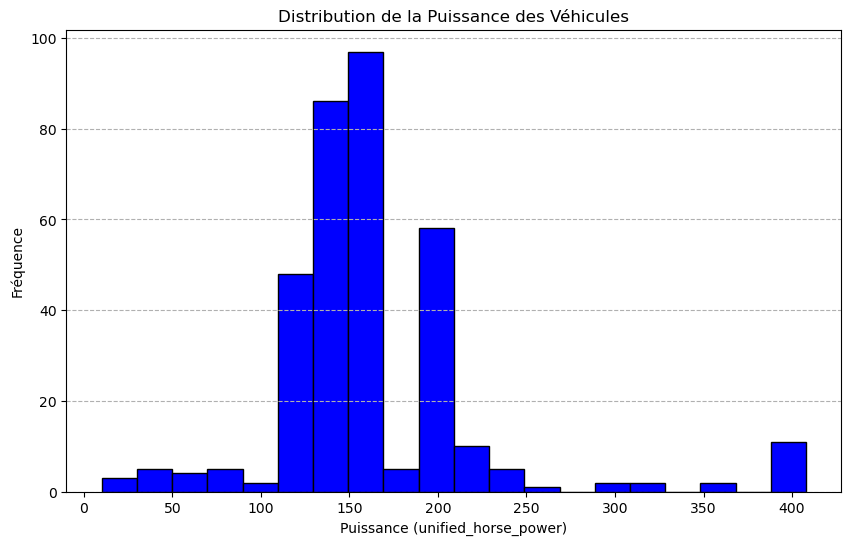

In [44]:
horsepower_data = co2_data_df.filter(F.col("unified_horse_power").isNotNull()) \
                             .select("unified_horse_power") \
                             .rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.hist(horsepower_data, bins=20, color='blue', edgecolor='black')
plt.xlabel("Puissance (unified_horse_power)")
plt.ylabel("Fréquence")
plt.title("Distribution de la Puissance des Véhicules")
plt.grid(axis='y', linestyle='--')
plt.show()

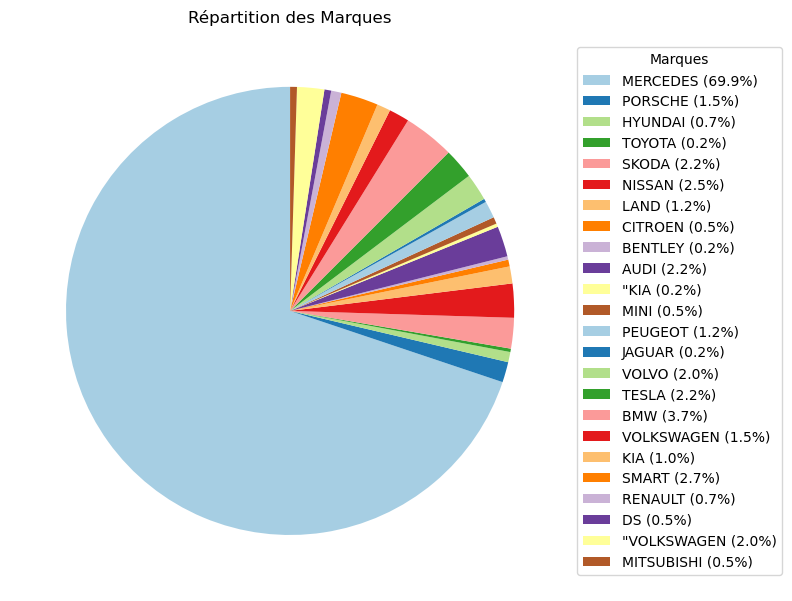

In [45]:
# print("Nombre de marques différentes :", co2_df.select("marque").distinct().count())
# co2_df.groupBy("marque").count().orderBy(F.desc("count")).show()

# Récupérer la distribution des marques
brand_distribution = co2_df.groupBy("marque").count().toPandas()

# Calcul des pourcentages
brand_distribution["percentage"] = (brand_distribution["count"] / brand_distribution["count"].sum()) * 100

# Tracer le camembert
plt.figure(figsize=(8, 8))
plt.pie(
    brand_distribution["count"], 
    startangle=90,  # Faire démarrer le camembert à 90°
    colors=plt.cm.Paired.colors  # Palette de couleurs
)

# Créer les étiquettes (nom de la marque + pourcentage)
labels = [
    f"{row['marque']} ({row['percentage']:.1f}%)" 
    for _, row in brand_distribution.iterrows()
]

# Ajouter une légende avec les noms et pourcentages
plt.legend(
    labels, 
    title="Marques", 
    loc="center left", 
    bbox_to_anchor=(1, 0.5),  # Positionner la légende à droite
    fontsize=10
)

# Ajouter un titre
plt.title("Répartition des Marques")
plt.tight_layout()
plt.show()



In [46]:
co2_df = co2_df.withColumn("bonus_malus", F.col("bonus_malus").cast("float")) \
               .withColumn("rejets_co2", F.col("rejets_co2").cast("float"))

correlation = co2_df.stat.corr("bonus_malus", "rejets_co2")
print(f"Corrélation entre bonus_malus et rejets_co2 : {correlation}")

Corrélation entre bonus_malus et rejets_co2 : 0.221516967483021


+------+------+-------------------+
|marque|modele|unified_horse_power|
+------+------+-------------------+
|  AUDI|E-TRON|              408.0|
|  AUDI|E-TRON|              408.0|
|  LAND| ROVER|              404.0|
|  LAND| ROVER|              404.0|
|  LAND| ROVER|              404.0|
|  LAND| ROVER|              404.0|
|  LAND| ROVER|              404.0|
| VOLVO|   V90|              390.0|
| VOLVO|  XC90|              390.0|
| VOLVO|  XC60|              390.0|
+------+------+-------------------+
+--------------------+-----+
|bonus_malus_category|count|
+--------------------+-----+
|   Neutre ou Inconnu|   79|
|               Bonus|  278|
|               Malus|   51|
+--------------------+-----+


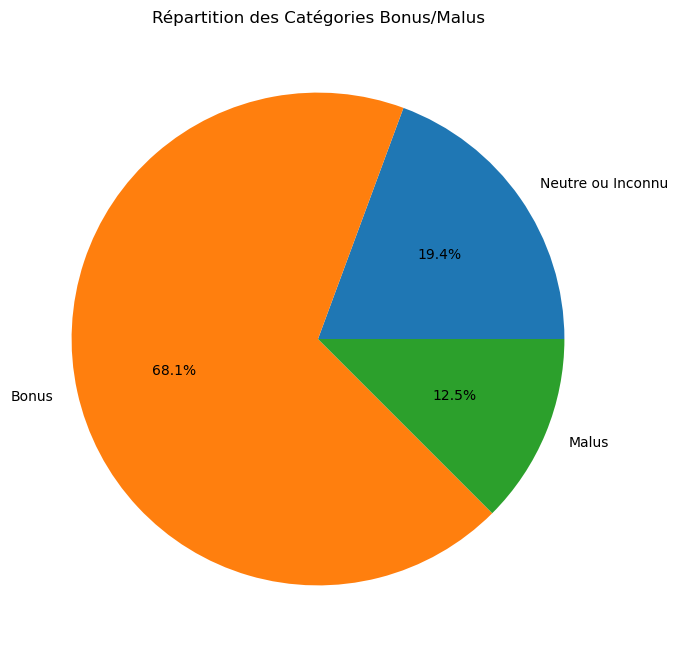

In [47]:

co2_df.orderBy(F.desc("unified_horse_power")).select("marque", "modele", "unified_horse_power").show(10)

co2_df = co2_df.withColumn(
    "bonus_malus_category",
    F.when(F.col("bonus_malus") > 0, "Bonus")
    .when(F.col("bonus_malus") < 0, "Malus")
    .otherwise("Neutre ou Inconnu")
)

co2_df.groupBy("bonus_malus_category").count().show()
bonus_distribution = co2_df.groupBy("bonus_malus_category").count().toPandas()
plt.figure(figsize=(8, 8))
plt.pie(bonus_distribution["count"], labels=bonus_distribution["bonus_malus_category"], autopct="%1.1f%%")
plt.title("Répartition des Catégories Bonus/Malus")
plt.show()



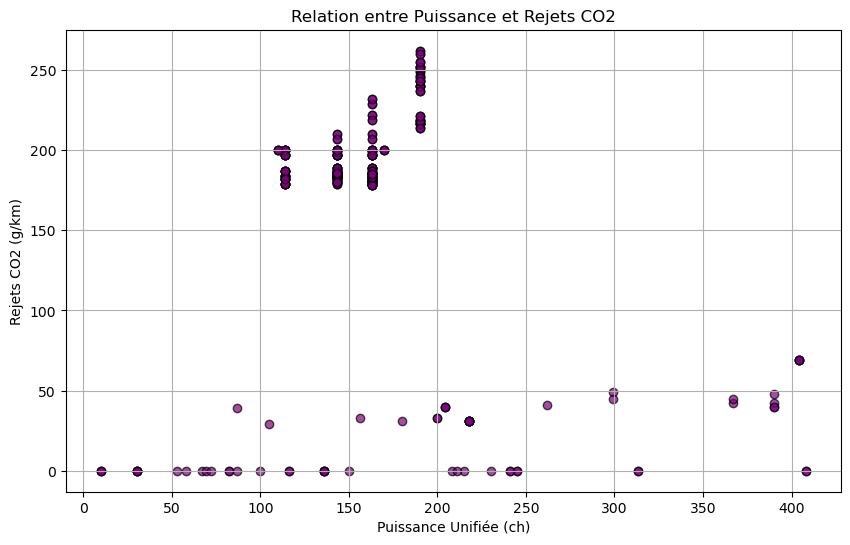

In [48]:
horsepower_data = co2_df.select("unified_horse_power", "rejets_co2").rdd.map(tuple).collect()
horsepower, co2 = zip(*horsepower_data)

plt.figure(figsize=(10, 6))
plt.scatter(horsepower, co2, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel("Puissance Unifiée (ch)")
plt.ylabel("Rejets CO2 (g/km)")
plt.title("Relation entre Puissance et Rejets CO2")
plt.grid(True)
plt.show()


La relation semble non linéaire :
Pour des puissances faibles à modérées (<150 ch), les rejets CO₂ augmentent significativement.
À mesure que la puissance augmente au-delà de 200 ch, les rejets CO₂ diminuent ou restent constants pour certains véhicules.
Cela peut être dû à la présence de véhicules électriques et hybrides puissants, qui produisent peu ou pas de CO₂.

Les points ne forment pas une tendance claire. Cela est cohérent avec la faible corrélation calculée précédemment (-0.05), indiquant que la puissance n'est pas un facteur déterminant pour les rejets de CO₂ dans ce dataset.

In [49]:
co2_df.groupBy("marque").agg(F.avg("unified_horse_power").alias("avg_horse_power")) \
      .orderBy(F.desc("avg_horse_power")).show(10)


+-----------+------------------+
|     marque|   avg_horse_power|
+-----------+------------------+
|       LAND|             404.0|
|       AUDI| 330.8888888888889|
|      VOLVO| 318.1666666666667|
|      TESLA|219.11111111111111|
|"VOLKSWAGEN|             218.0|
|         DS|             168.0|
|   MERCEDES| 154.2941176470588|
|    PEUGEOT|            145.75|
| VOLKSWAGEN|140.66666666666666|
|     NISSAN|             140.0|
+-----------+------------------+


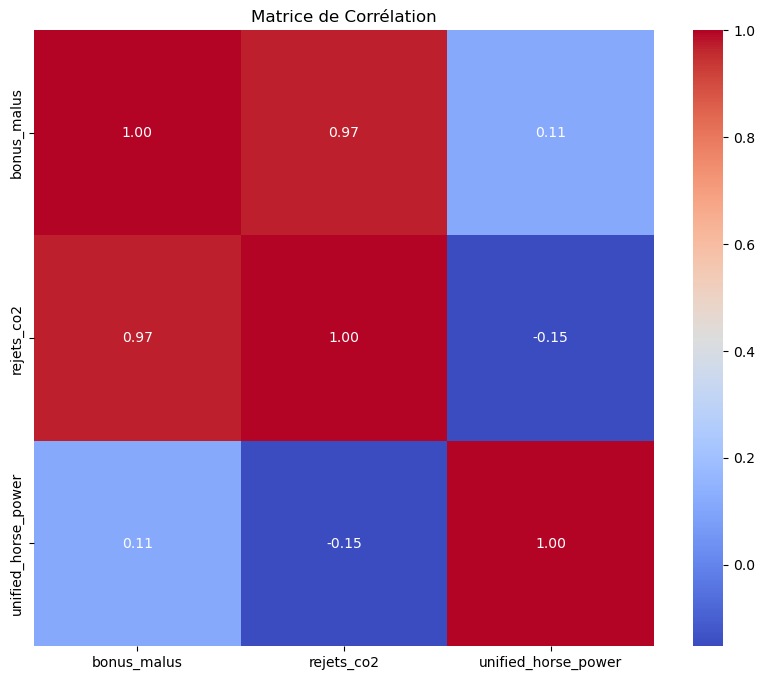

Corrélation entre bonus_malus et rejets_co2 : 0.221516967483021
Corrélation entre unified_horse_power et rejets_co2 : 0.004266095981507087


In [50]:
import seaborn as sns
import pandas as pd

# Convertir le DataFrame Spark en pandas pour visualisation
corr_data = co2_df.select("bonus_malus", "rejets_co2", "unified_horse_power").toPandas()
corr_matrix = corr_data.corr()  # Calculer la matrice de corrélation

# Tracer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de Corrélation")
plt.show()
# Calculer et afficher les corrélations
correlations = co2_df.stat.corr("bonus_malus", "rejets_co2")
print(f"Corrélation entre bonus_malus et rejets_co2 : {correlations}")

correlations_hp = co2_df.stat.corr("unified_horse_power", "rejets_co2")
print(f"Corrélation entre unified_horse_power et rejets_co2 : {correlations_hp}")

Il y a une très faible corrélation positive entre bonus_malus et rejets_co2.
Cela suggère que les véhicules avec des émissions de CO2 plus élevées tendent légèrement à avoir un malus plus important, mais l'effet est faible. 
Cette corrélation, bien que faible, est conforme au fonctionnement du système bonus/malus, qui pénalise les véhicules émettant davantage de CO₂.


Il y a une très faible corrélation pratiquement nulle entre unified_horse_power (puissance des véhicules) et rejets_co2.
Cela indique qu'une augmentation de la puissance n'est pas fortement liée à une augmentation des rejets de CO2. En réalité, les véhicules puissants (par exemple, hybrides ou électriques) peuvent avoir des émissions faibles.

In [51]:
from pyspark.sql.functions import mean, stddev

# Étape 1 : Calcul de la moyenne et de l'écart-type pour la colonne 'unified_horse_power'
stats = co2_df.select(
    mean("unified_horse_power").alias("mean"),  # Calcule la moyenne de la colonne
    stddev("unified_horse_power").alias("stddev")  # Calcule l'écart-type de la colonne
).first()  # Récupère les résultats sous forme d'un seul objet (Row)

# Extraction des valeurs de la moyenne et de l'écart-type depuis l'objet Row
mean_hp, stddev_hp = stats["mean"], stats["stddev"]

# Étape 2 : Détection des valeurs aberrantes (outliers)
outliers = co2_df.filter(
    (F.col("unified_horse_power") > mean_hp + 3 * stddev_hp) |  # Valeurs supérieures à (moyenne + 3 x écart-type)
    (F.col("unified_horse_power") < mean_hp - 3 * stddev_hp)    # Valeurs inférieures à (moyenne - 3 x écart-type)
)

# Étape 3 : Afficher le nombre de valeurs aberrantes trouvées
print(f"Nombre de valeurs aberrantes : {outliers.count()}")  # Compte le nombre de lignes correspondant aux outliers

# Étape 4 : Afficher les valeurs aberrantes
print("Valeurs aberrantes :")
outliers.select("marque", "modele", "horse_power", "unit", "rejets_co2").show()



Nombre de valeurs aberrantes : 13
Valeurs aberrantes :
+------+------+-----------+----+----------+
|marque|modele|horse_power|unit|rejets_co2|
+------+------+-----------+----+----------+
|  AUDI|E-TRON|      408.0|  ch|       0.0|
|  AUDI|E-TRON|      408.0|  ch|       0.0|
|  AUDI|    A7|      367.0|  ch|      42.0|
|  LAND| ROVER|      404.0|  ch|      69.0|
| VOLVO|  XC90|      390.0|  ch|      48.0|
|  AUDI|    Q5|      367.0|  ch|      45.0|
|  LAND| ROVER|      404.0|  ch|      69.0|
|  LAND| ROVER|      404.0|  ch|      69.0|
| VOLVO|  XC60|      390.0|  ch|      42.0|
| VOLVO|   S90|      390.0|  ch|      40.0|
| VOLVO|   V90|      390.0|  ch|      40.0|
|  LAND| ROVER|      404.0|  ch|      69.0|
|  LAND| ROVER|      404.0|  ch|      69.0|
+------+------+-----------+----+----------+


# **Fermeture de la Session Spark**

In [52]:
spark.stop()
print("Session Spark arrêtée avec succès.")

Session Spark arrêtée avec succès.
